# Multiomics BRDC Paper — Figure 6

This Jupyter Notebook (with Python 3 kernel) contained the code of the proteogenomic analysis between IDC and M-Distant.

Input files:  
* The clinical file: clinical.csv
* The copy number alteration file: cna.csv
* The gene copy number file: gcnv.csv
* The gene location file: gene_loc.csv
* The microenvironment file: microenvironment.csv
* The xcell file: xcell.csv
* The proteome file: pro.csv
* The phospho-proteome file: phosphoproteome.csv
* The proteome-based ssGSEA score: pscore.csv
* The phosphoproteome-based ssGSEA score: phoscore.csv
* The DNA repair ssgsea score: repair_score.csv

Output figures and tables:  
* Figure 6A, 6B, 6C, 6D, 6E, 6F, 6G, 6I, and 6J
* Supplementary Table 7B

In [18]:
from brdc_utils import *

import warnings
warnings.filterwarnings("ignore")

In [19]:
outpaths = ['../figure/fig6', '../documents/fig6']
for outpath in outpaths:
    if not os.path.isdir(outpath):
        os.mkdir(outpath)

clinical = pd.read_csv('../document/clinical.csv', index_col=0)
cnv = pd.read_csv('../document/cnv.csv', index_col=0)
gcnv = pd.read_csv('../document/gcnv.csv', index_col=0)
gene_loc = pd.read_csv('../document/gene_loc.csv', index_col=0)
me = pd.read_csv('../document/microenvironment.csv', index_col=0)
pro = pd.read_csv('../document/proteome.csv', index_col=0)
pho = pd.read_csv('../document/phosphoproteome.csv', index_col=0)
xcell = pd.read_csv('../document/xcell.csv', index_col=0)
pscore = pd.read_csv('../document/pscore.csv', index_col=0)
phoscore = pd.read_csv('../document/phoscore.csv', index_col=0)
repairscore = pd.read_csv('../document/repair_score.csv', index_col=0)

order_ = ['IDC', 'M-Distant']
organ_order_ = ['M-Liver', 'M-Bone', 'M-Chestwall', 'M-Lung', 'M-Brain', 'M-Pleural']
palette = ['#6fc5c7', '#8d3890']
organ_palette = ['#f9c0c0', '#f4a259', '#93d384', '#68d8d6', '#00b4d8', '#0077b6']

import matplotlib.colors as mcolors
cmap = mcolors.LinearSegmentedColormap.from_list("blue_red_gradient", ['#348dcd', 'white', '#e83720'], N=256)

In [20]:
from collections import defaultdict

dist_arm = combine(clinical, cnv, 'substage_with_DCIS_annot', part_element=order_).droplevel(0)
dist_pro = combine(clinical, pro, 'substage_with_DCIS_annot', part_element=order_).T
dist_gcnv = combine(clinical, gcnv, 'substage_with_DCIS_annot', part_element=order_).T

# arm event AB group analysis
arm_table = group_table(dist_arm, prestatistic_method=None)

# arm event survival analysis
df = pd.concat([cnv.T, clinical[['OS_state', 'OS_time']]], axis=1, join='inner')
survival_out = defaultdict(dict)
for arm in df.columns[:-2]:
    tmp = df[[arm, 'OS_state', 'OS_time']]
    tmp[arm] = tmp[arm].apply(lambda x: 'high' if x > tmp[arm].median() else 'low')
    survival_out[arm] = multi_logrank(tmp)
arm_survival_df = pd.DataFrame().from_dict(survival_out, orient='index', columns=['logrank_prob'])

ab_sig_arms = arm_table.query("(ranksums<0.05)&(`IDC_vs_M-Distant`<0)&(`M-Distant`>0.1)").index
survival_sig_arms = arm_survival_df.query("logrank_prob<0.05").index
sig_arms = np.intersect1d(ab_sig_arms, survival_sig_arms)
arms = sig_arms[list(map(lambda x: x.endswith(('p', 'q')), sig_arms))]
arm = arm_survival_df.loc[arms].sort_values('logrank_prob').index[0]
genes = np.intersect1d(pro.index, gene_loc.loc[gene_loc.index.str.startswith(arm)])

# proteome AB group analysis
pro_table = group_table(dist_pro.T.droplevel(0))
genes = pro_table.loc[genes].query("(ranksums_fdr<0.01)&(`IDC_vs_M-Distant`<0.67)").index

# gene copy number AB group analysis
gcnv_table = group_table(dist_gcnv.T.droplevel(0), one_tile=True)
genes = gcnv_table.loc[genes].query("(ranksums<0.05)&(`IDC_vs_M-Distant`<0)").index

# gene copy number survival analysis
df = pd.concat([pro.loc[genes].T, clinical[['OS_state', 'OS_time']]], axis=1, join='inner')
survival_out = defaultdict(dict)
for arm in df.columns[:-2]:
    tmp = df[[arm, 'OS_state', 'OS_time']]
    tmp[arm] = tmp[arm].apply(lambda x: 'high' if x > tmp[arm].median() else 'low')
    survival_out[arm] = multi_logrank(tmp)
pro_survival_df = pd.DataFrame().from_dict(survival_out, orient='index', columns=['logrank_prob'])
genes = pro_survival_df.loc[genes].query("logrank_prob<0.05").index

# cis-effect analysis
corr_out = defaultdict(dict)
for gene in genes:
    *_, rho, prob = correlation(dist_pro.droplevel(1, 1).loc[gene], dist_gcnv.droplevel(1, 1).loc[gene])
    corr_out[gene]['spearman rho'] = rho
    corr_out[gene]['spearman prob'] = prob

corr_df = pd.DataFrame().from_dict(corr_out, orient='index').sort_values('spearman prob')
genes = corr_df.query("(`spearman prob`<0.05)&(`spearman rho`>0)").index
print(list(genes))

['NANP', 'PCNA', 'APMAP', 'FAM182B', 'DTD1']


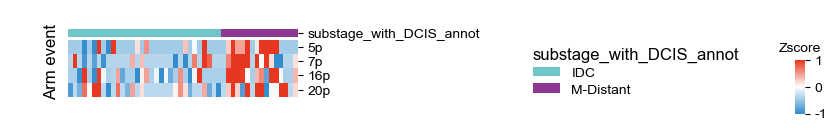

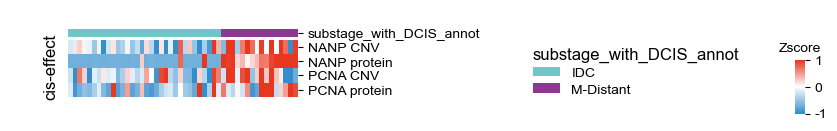

In [21]:
# Figure 4A (top panel)

plotdata = dist_arm[ab_sig_arms[list(map(lambda x: x.endswith(('p', 'q')), ab_sig_arms))]].iloc[:, [2, 3, 0, 1]].sort_index().T

fig = heatmap(plotdata, lut={'substage_with_DCIS_annot': dict(zip(order_, palette))}, z_score=0, cmap=cmap, figsize=(5, 1.4), colors_ratio=.1, cbar_pos=(1.6, .15, .02, .38))
fig.ax_cbar.set_title('Zscore', fontsize=10)
fig.ax_heatmap.text(-5, 4, 'Arm event', fontsize=12, rotation='vertical')
fig.savefig('../figure/fig6/figure6A_top-panel_arm_heatmap.pdf', bbox_inches='tight')

plotdata = pd.concat([dist_pro.loc[genes[:2]].rename(index=lambda x: x + ' protein'), dist_gcnv.loc[genes[:2]].rename(index=lambda x: x + ' CNV')], join='inner').sort_index().sort_index(level=1, axis=1)
fig = heatmap(plotdata, lut={'substage_with_DCIS_annot': dict(zip(order_, palette))}, z_score=0, figsize=(5, 1.4), colors_ratio=0.1, cmap=cmap, cbar_pos=(1.6, .15, .02, .38))
fig.ax_cbar.set_title('Zscore', fontsize=10)
fig.ax_heatmap.text(-5, 4, 'cis-effect', fontsize=12, rotation='vertical')
fig.savefig('../figure/fig6/figure6A_top-panel_gene_heatmap.pdf', bbox_inches='tight')

enriched in M-Distant than IDC: Adipocytes, CD4+ Tem, CD4+ memory T-cells, CD8+ T-cells, CD8+ naive T-cells, Chondrocytes, Endothelial cells, Keratinocytes, MPP, Macrophages, Macrophages M2, Melanocytes, Myocytes, NKT, Plasma cells, Sebocytes, Skeletal muscle, Th1 cells, aDC, pDC


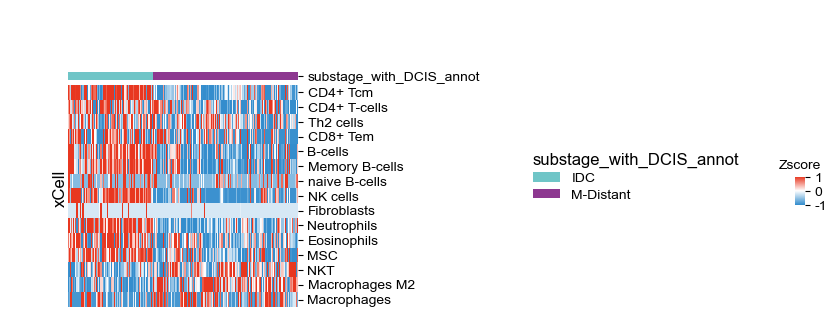

In [22]:
# Figure 4A (top-middle panel), Supplementary_Table_7B

dist_xcell = combine(clinical, xcell, 'substage_with_DCIS_annot', part_element=order_)
dist_xcell_table = group_table(dist_xcell.droplevel(0), prestatistic_method=None)
print("enriched in M-Distant than IDC: {}".format(', '.join(dist_xcell_table.query('(ttest<0.05)&(`IDC_vs_M-Distant`<1)').index.tolist())))

cells = ['CD4+ Tcm', 'CD4+ T-cells', 'Th2 cells', 'CD8+ Tem', 'B-cells', 'Memory B-cells', 'naive B-cells', 'NK cells', 'Fibroblasts', 'Neutrophils', 'Eosinophils', 'MSC', 'NKT', 'Macrophages M2', 'Macrophages']

plotdata = dist_xcell[cells].droplevel(0).sort_index().T
fig = heatmap(plotdata, lut={'substage_with_DCIS_annot': dict(zip(order_, palette))}, z_score=0, cmap=cmap, figsize=(5, 3.5), colors_ratio=.03, cbar_pos=(1.6, .4, .02, .08))
fig.ax_cbar.set_title('Zscore', fontsize=10)
fig.ax_heatmap.text(-14, 8, 'xCell', fontsize=12, rotation='vertical')
fig.savefig('../figure/fig6/figure6A_top-middle-panel_xCell_heatmap.pdf', bbox_inches='tight')

out_table = dist_xcell_table.iloc[:, [1, 0, -1]].dropna().rename_axis('Term')
out_table.columns = 'M-Distant mean', 'IDC mean', 'Adjusted ranksums p-value'
out_table.to_csv('../documents/fig6/Supplementary_Table_7B_left.csv')

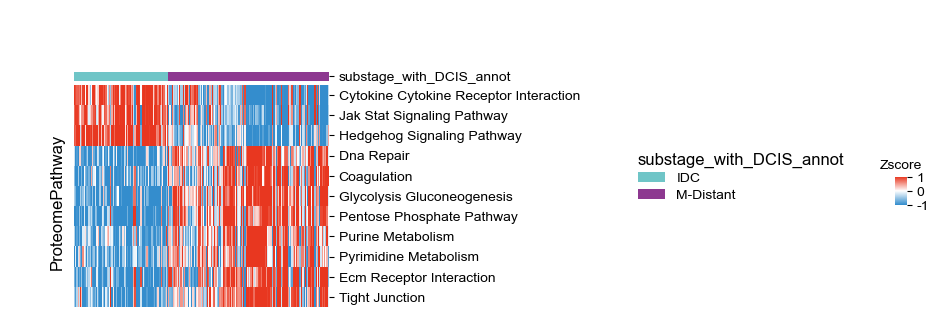

In [23]:
# Figure 4A (bottom-middle panel), Supplementary_Table_7B

dist_pscore = combine(clinical, pscore, 'substage_with_DCIS_annot', part_element=order_)
dist_pscore_table = group_table(dist_pscore.droplevel(0), prestatistic_method=None)

pathways = ['KEGG_CYTOKINE_CYTOKINE_RECEPTOR_INTERACTION', 'KEGG_JAK_STAT_SIGNALING_PATHWAY', 'KEGG_HEDGEHOG_SIGNALING_PATHWAY', 'HALLMARK_DNA_REPAIR', 'HALLMARK_COAGULATION', 'KEGG_GLYCOLYSIS_GLUCONEOGENESIS', 'KEGG_PENTOSE_PHOSPHATE_PATHWAY', 'KEGG_PURINE_METABOLISM', 'KEGG_PYRIMIDINE_METABOLISM', 'KEGG_ECM_RECEPTOR_INTERACTION', 'KEGG_TIGHT_JUNCTION']

plotdata = dist_pscore[pathways].droplevel(0).sort_index().T
fig = heatmap(plotdata, lut={'substage_with_DCIS_annot': dict(zip(order_, palette))}, z_score=0, cmap=cmap, figsize=(6, 3.5), colors_ratio=.03, cbar_pos=(1.5, .4, .02, .08), yticklabels=list(map(lambda x: x.split('_', 1)[1].replace('_', ' ').title(), plotdata.index)))
fig.ax_cbar.set_title('Zscore', fontsize=10)
fig.ax_heatmap.text(-20, 9, 'ProteomePathway', fontsize=12, rotation='vertical')
fig.savefig('../figure/fig6/figure6A_bottom-middle-panel_pscore_heatmap.pdf', bbox_inches='tight')

out_table = dist_pscore_table.iloc[:, [1, 0, -1]].dropna().rename_axis('Term')
out_table.columns = 'M-Distant mean', 'IDC mean', 'Adjusted ranksums p-value'
out_table.to_csv('../documents/fig6/Supplementary_Table_7B_right.csv')

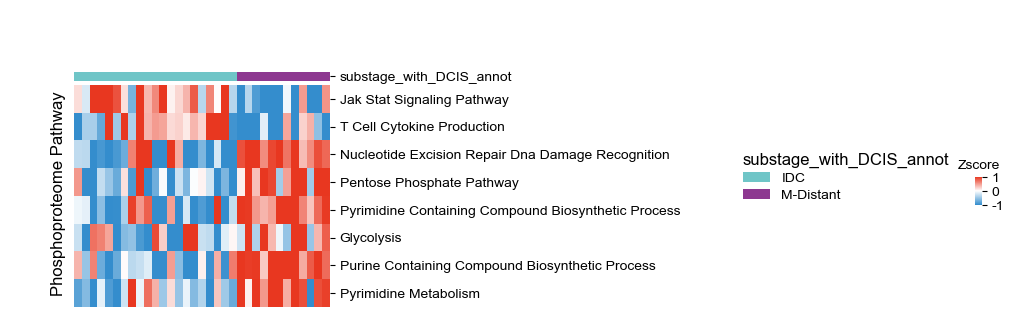

In [24]:
# Figure 4A (bottom panel)

dist_phoscore = combine(clinical, phoscore, 'substage_with_DCIS_annot', part_element=order_)
dist_phoscore_table = group_table(dist_phoscore.droplevel(0), prestatistic_method=None)

pathways = ['KEGG_JAK_STAT_SIGNALING_PATHWAY', 'GOBP_T_CELL_CYTOKINE_PRODUCTION', 'GOBP_NUCLEOTIDE_EXCISION_REPAIR_DNA_DAMAGE_RECOGNITION', 'KEGG_PENTOSE_PHOSPHATE_PATHWAY', 'GOBP_PYRIMIDINE_CONTAINING_COMPOUND_BIOSYNTHETIC_PROCESS', 'HALLMARK_GLYCOLYSIS', 'GOBP_PURINE_CONTAINING_COMPOUND_BIOSYNTHETIC_PROCESS', 'KEGG_PYRIMIDINE_METABOLISM']

plotdata = dist_phoscore[pathways].droplevel(0).sort_index().T
fig = heatmap(plotdata, lut={'substage_with_DCIS_annot': dict(zip(order_, palette))}, z_score=0, cmap=cmap, figsize=(7, 3.5), colors_ratio=.03, cbar_pos=(1.4, .4, .01, .08), yticklabels=list(map(lambda x: x.split('_', 1)[1].replace('_', ' ').title(), plotdata.index)))
fig.ax_cbar.set_title('Zscore', fontsize=10)
fig.ax_heatmap.text(-3, 7.5, 'Phosphoproteome Pathway', fontsize=12, rotation='vertical')
fig.savefig('../figure/fig6/figure6A_bottom-panel_phoscore_heatmap.pdf', bbox_inches='tight')

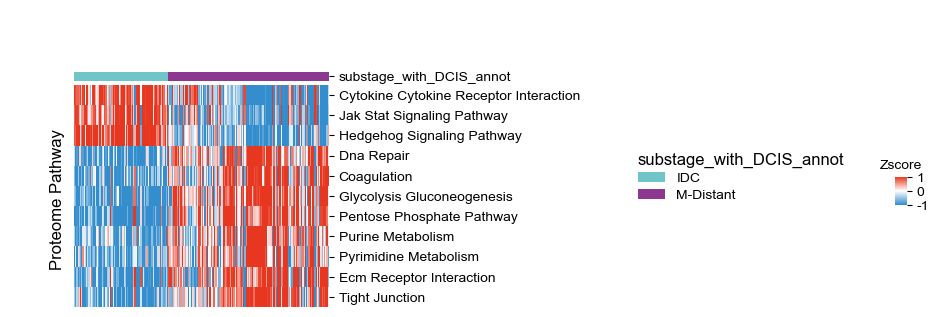

In [25]:
# Figure 4A (bottom-middle panel)

dist_pscore = combine(clinical, pscore, 'substage_with_DCIS_annot', part_element=order_)
dist_pscore_table = group_table(dist_pscore.droplevel(0), prestatistic_method=None)

pathways = ['KEGG_CYTOKINE_CYTOKINE_RECEPTOR_INTERACTION', 'KEGG_JAK_STAT_SIGNALING_PATHWAY', 'KEGG_HEDGEHOG_SIGNALING_PATHWAY', 'HALLMARK_DNA_REPAIR', 'HALLMARK_COAGULATION', 'KEGG_GLYCOLYSIS_GLUCONEOGENESIS', 'KEGG_PENTOSE_PHOSPHATE_PATHWAY', 'KEGG_PURINE_METABOLISM', 'KEGG_PYRIMIDINE_METABOLISM', 'KEGG_ECM_RECEPTOR_INTERACTION', 'KEGG_TIGHT_JUNCTION']

plotdata = dist_pscore[pathways].droplevel(0).sort_index().T
fig = heatmap(plotdata, lut={'substage_with_DCIS_annot': dict(zip(order_, palette))}, z_score=0, cmap=cmap, figsize=(6, 3.5), colors_ratio=.03, cbar_pos=(1.5, .4, .02, .08), yticklabels=list(map(lambda x: x.split('_', 1)[1].replace('_', ' ').title(), plotdata.index)))
fig.ax_cbar.set_title('Zscore', fontsize=10)
fig.ax_heatmap.text(-20, 9, 'Proteome Pathway', fontsize=12, rotation='vertical')
fig.savefig('../figure/fig6/figure6A_bottom-middle-panel_pscore_heatmap.pdf', bbox_inches='tight')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


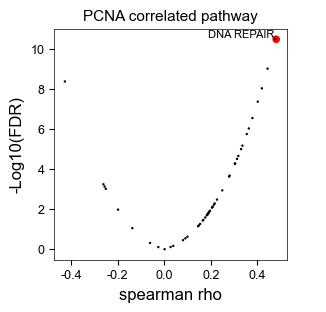

In [26]:
# Figure 6B

tmp = combine(clinical, pro, 'substage_with_DCIS_annot', 'PCNA', how='inner', part_element=order_)

table = pscore.apply(correlation, y=tmp.droplevel(1), axis=1, result_type='expand')
table.columns = 'pearson corr', 'pearson prob', 'spearman rho', 'spearman prob'
table['spearman fdr'] = fdr(table['spearman prob'])[1]
plotdata = table.filter(like='HALLMARK', axis=0).sort_values('spearman prob')[['spearman rho', 'spearman fdr']]

plotdata.iloc[:, 1] = -np.log10(plotdata.iloc[:, 1])
plotdata.loc['HALLMARK_DNA_REPAIR', 'annot'] = 'annotated'
plotdata.loc[:, 'annot'] = plotdata.loc[:, 'annot'].fillna('others')
plotdata['size'] = plotdata['annot']
ax = scatterplot(plotdata.iloc[:, [0, 2, 1]], highlight_points=['HALLMARK_DNA_REPAIR'], title='PCNA correlated pathway', palette=['red', 'black'], sizes=[30, 3], ticklabels_format=[], ticklabels_hide=[], legend=False, spines_hide=[])
ax.set_ylabel('-Log10(FDR)')
ax.get_figure().savefig('../figure/fig6/figure6B_scatterplot.pdf', bbox_inches='tight')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


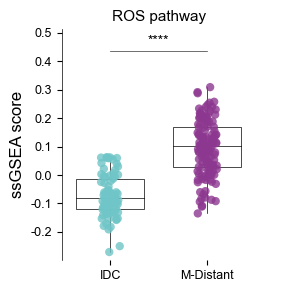

In [27]:
# Figure 6C

plotdata = combine(clinical, pscore, 'substage_with_DCIS_annot', ['HALLMARK_DNA_REPAIR'], part_element=order_).sort_index(level=1, axis=0).droplevel(0)
ax = cateplot(plotdata, ticklabels_format=[], palette=dict(zip(order_, palette)), labels_hide=['x'], title='ROS pathway', log_transform='no')
ax.set_ylabel('ssGSEA score')
ax.get_figure().savefig('../figure/fig6/figure6C_cateplot.pdf', bbox_inches='tight')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


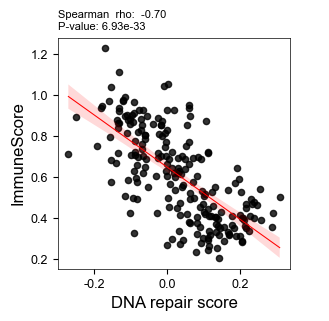

In [28]:
# Figure 6D

samples = clinical.query("substage_with_DCIS_annot in @order_").index
df = pd.concat([pscore.loc['HALLMARK_DNA_REPAIR'].rename('DNA repair score'), me.loc['ImmuneScore']], axis=1).loc[samples]
ax = regplot(df, ticklabels_format=[])
ax.get_figure().savefig('../figure/fig6/figure6E_regplot.pdf', bbox_inches='tight')

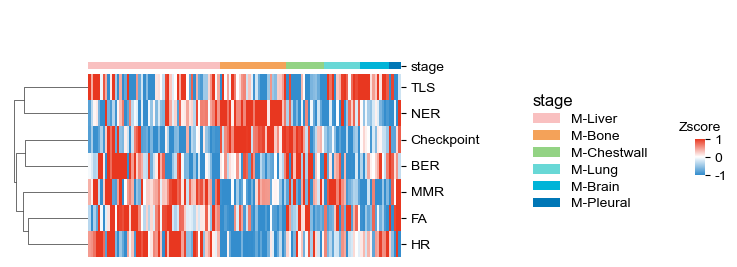

In [29]:
# Figure 6G

plotdata = combine(clinical, repairscore, 'stage', how='inner', part_element=organ_order_).droplevel(0).loc[organ_order_].T
fig = heatmap(plotdata, lut={'stage': dict(zip(organ_order_, organ_palette))}, z_score=0, cmap=cmap, figsize=(5, 3), colors_ratio=.03, cbar_pos=(1.4, .4, .02, .12), row_cluster=True)
fig.ax_cbar.set_title('Zscore', fontsize=10)
fig.savefig('../figure/fig6/figure6G_repair-score_heatmap.pdf', bbox_inches='tight')

Text(0.5, 1.0, 'Zscore')

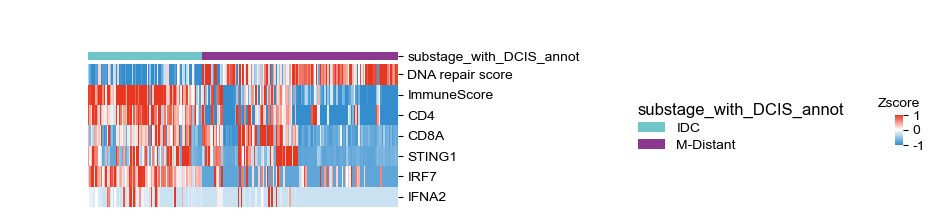

In [30]:
# Figure 6F (top-panel)

tmp = combine(clinical, pro, 'substage_with_DCIS_annot', ['CD4', 'CD8A', 'STING1', 'IRF7', 'IFNA2'], how='inner', part_element=order_).rename_axis(['Exp', 'substage_with_DCIS_annot'])
plotdata = pd.merge(df, tmp, right_on='Exp', left_index=True, how='inner').sort_index(level=1).T
fig = heatmap(plotdata, lut={'substage_with_DCIS_annot': dict(zip(order_, palette))}, z_score=0, cmap=cmap, figsize=(6, 2.5), colors_ratio=.04, cbar_pos=(1.5, .4, .013, .12))
fig.ax_cbar.set_title('Zscore', fontsize=10)


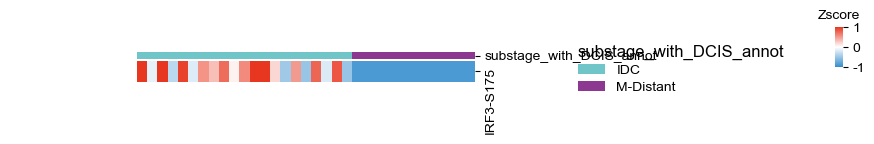

In [31]:
# Figure 6F (middle-panel)

plotdata = combine(clinical, pho, 'substage_with_DCIS_annot', ['IRF3-S175'], how='inner', part_element=order_).rename_axis(['Exp', 'substage_with_DCIS_annot']).sort_index(level=1).T
fig = heatmap(plotdata, lut={'substage_with_DCIS_annot': dict(zip(order_, palette))}, z_score=0, cmap=cmap, figsize=(6, .5), colors_ratio=.2, cbar_pos=(1.5, .4, .013, .8))
fig.ax_heatmap.set_yticklabels(fig.ax_heatmap.get_yticklabels(), rotation=90)
fig.ax_cbar.set_title('Zscore', fontsize=10)
fig.savefig('../figure/fig6/figure6F_middle-panel_heatmap.pdf', bbox_inches='tight')

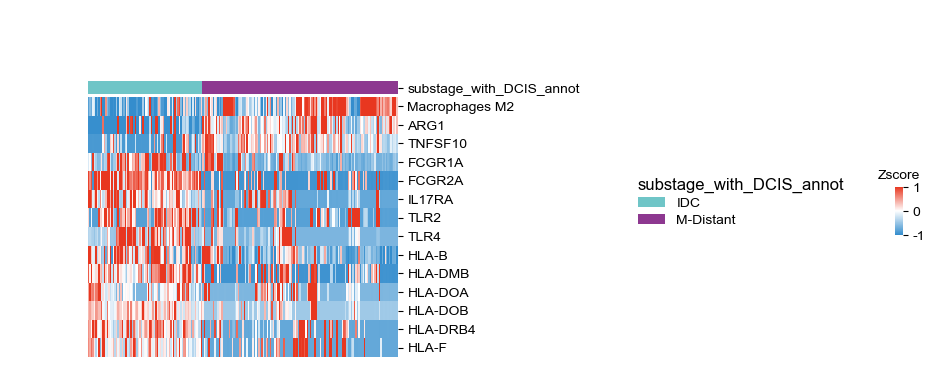

In [32]:
# Figure 6F (bottom-panel)

tmp1 = combine(clinical, xcell, 'substage_with_DCIS_annot', ['Macrophages M2'], how='inner', part_element=order_).rename_axis(['Exp', 'substage_with_DCIS_annot']).sort_index(level=1)
tmp2 = combine(clinical, pro, 'substage_with_DCIS_annot', ['ARG1', 'TNFSF10', 'FCGR1A', 'FCGR2A', 'IL17RA', 'TLR2', 'TLR4', 'HLA-B', 'HLA-DMB', 'HLA-DOA', 'HLA-DOB', 'HLA-DRB4', 'HLA-F'], how='inner', part_element=order_).rename_axis(['Exp', 'substage_with_DCIS_annot']).sort_index(level=1)

plotdata = pd.concat([tmp1, tmp2], axis=1).T
fig = heatmap(plotdata, lut={'substage_with_DCIS_annot': dict(zip(order_, palette))}, z_score=0, cmap=cmap, figsize=(6, 4), colors_ratio=.04, cbar_pos=(1.5, .4, .013, .12))
fig.ax_cbar.set_title('Zscore', fontsize=10)
fig.savefig('../figure/fig6/figure6F_bottom-panel_heatmap.pdf', bbox_inches='tight')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


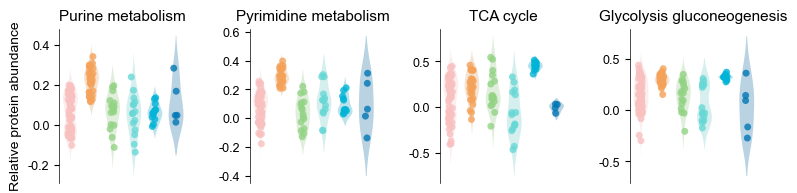

In [33]:
fig, axs = plt.subplots(1, 4, figsize=(9, 2))
plt.subplots_adjust(wspace=.5)
pathways = ['KEGG_PURINE_METABOLISM', 'KEGG_PYRIMIDINE_METABOLISM', 'KEGG_CITRATE_CYCLE_TCA_CYCLE', 'KEGG_GLYCOLYSIS_GLUCONEOGENESIS']
annots = ['Purine metabolism', 'Pyrimidine metabolism', 'TCA cycle', 'Glycolysis gluconeogenesis']
i = 0
for ax, pathway, annot in zip(axs, pathways, annots):
    plotdata = combine(clinical, pscore, 'stage', pathway, how='inner', part_element=organ_order_).droplevel(0).groupby('stage').apply(lambda x: filter_by_quantile(x[pathway])).droplevel(0).loc[organ_order_]
    ax = cateplot(plotdata, ax=ax, box_pairs=None, palette=dict(zip(organ_order_, organ_palette)), category_type=['violin', 'strip'], ticklabels_format=[], ticklabels_hide=['x'], stripsize=5, labels_hide=['x', 'y'])
    ax.set_xticks([])
    if i == 0:
        ax.set_ylabel('Relative protein abundance', fontsize=10)
    ax.set_title(annot, fontsize=11)
    i += 1
fig.savefig('../figure/fig6/figure6I_cateplot.pdf', bbox_inches='tight')

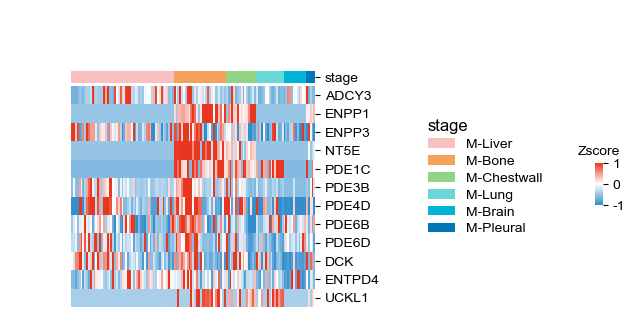

In [34]:
# Figure 6J (left panel)

genes = ['ADCY3', 'ENPP1', 'ENPP3', 'NT5E', 'PDE1C', 'PDE3B', 'PDE4D', 'PDE6B', 'PDE6D', 'DCK', 'ENTPD4', 'UCKL1']
plotdata = combine(clinical, pro, 'stage', genes, how='inner', part_element=organ_order_).droplevel(0).T[organ_order_]
fig = heatmap(plotdata, lut={'stage': dict(zip(organ_order_, organ_palette))}, z_score=0, cmap=cmap, figsize=(4, 3.5), colors_ratio=.04, cbar_pos=(1.5, .4, .02, .12))
fig.ax_cbar.set_title('Zscore', fontsize=10)
fig.savefig('../figure/fig6/figure6J_left-panel_heatmap.pdf', bbox_inches='tight')

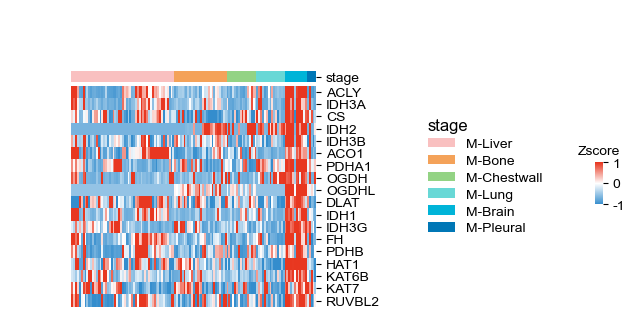

In [35]:
# Figure 6J (right panel)

genes = ['ACLY', 'IDH3A', 'CS', 'IDH2', 'IDH3B', 'ACO1', 'PDHA1', 'OGDH', 'OGDHL', 'DLAT', 'IDH1', 'IDH3G', 'FH', 'PDHB', 'HAT1', 'KAT6B', 'KAT7', 'RUVBL2']
plotdata = combine(clinical, pro, 'stage', genes, how='inner', part_element=organ_order_).droplevel(0).T[organ_order_]
fig = heatmap(plotdata, lut={'stage': dict(zip(organ_order_, organ_palette))}, z_score=0, cmap=cmap, figsize=(4, 3.5), colors_ratio=.04, cbar_pos=(1.5, .4, .02, .12))
fig.ax_cbar.set_title('Zscore', fontsize=10)
fig.savefig('../figure/fig6/figure6J_right-panel_heatmap.pdf', bbox_inches='tight')